**All The Library Imports Required For The Project**

For this part if the project, we have leveraged the use of NLKT, and re library for Data Pre-processing and then used Pytorch and Keras for tokeniztion and defining the LSTM model.

In [29]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, LancasterStemmer
from nltk.tokenize import RegexpTokenizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
import torch
import torch.optim as optim
import torch.nn as nn
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import precision_recall_curve, auc


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Data Preparation**

Loading the Data


In [2]:
train_file_path = "train.csv"
test_file_path = "test.csv"
test_labels_file_path = "testlabels.csv"

train_data = pd.read_csv(train_file_path, on_bad_lines="skip")
test_data = pd.read_csv(test_file_path, on_bad_lines="skip")
test_labels = pd.read_csv(test_labels_file_path, on_bad_lines="skip")

# Display the first few rows of the dataframes
print("Train DataFrame:")
print(train_data.head())

print("\nTest DataFrame:")
print(test_data.head())

print("\nTest Labels DataFrame:")
print(test_labels.head())


Train DataFrame:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  

Test DataFrame:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then

In [3]:
train_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [4]:
test_data

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


**Classes' Strength in Data**

In [5]:
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
data_array = train_data[categories].to_numpy()
non_toxic_mask = np.sum(data_array, axis=1) == 0

toxic_counts = np.sum(data_array, axis=0)
non_toxic_count = np.sum(non_toxic_mask)

result_df = pd.DataFrame({'labels': categories,'number_of_comments': toxic_counts})


print(result_df)
print(f" Number of non-toxic comments: {non_toxic_count}")




          labels  number_of_comments
0          toxic               15294
1   severe_toxic                1595
2        obscene                8449
3         threat                 478
4         insult                7877
5  identity_hate                1405
 Number of non-toxic comments: 143346


In [6]:
result_df

,labels,number_of_comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


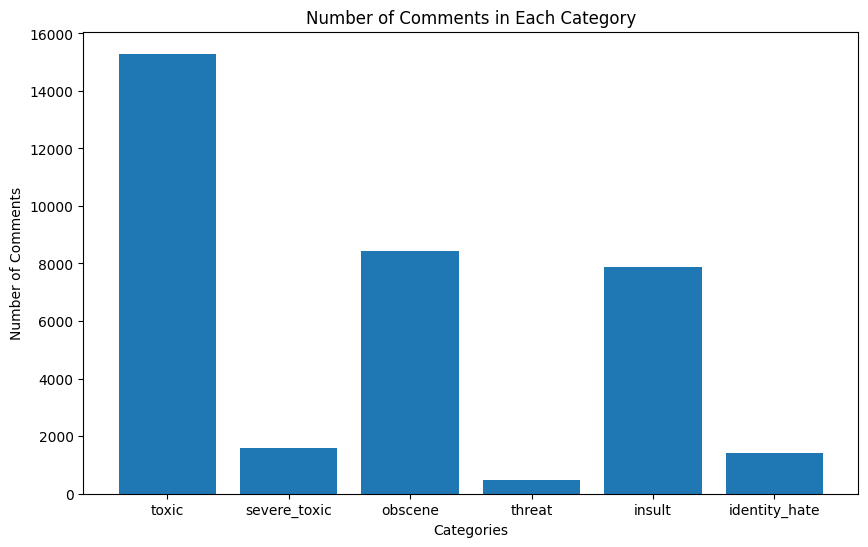

In [7]:
# Plot the number of comments in each category
plt.figure(figsize=(10, 6))
plt.bar(result_df['labels'], result_df['number_of_comments'])
plt.xlabel('Categories')
plt.ylabel('Number of Comments')
plt.title('Number of Comments in Each Category')
plt.show()

**Data PreProcessing**

In the following, we have  developed a text preprocessing function called process_text to refine and organize textual data for analysis. This function goes through several essential steps to clean the text effectively. Initially, we have remove any URLs present in the text by using regular expressions. Then, the text is cleaned by removing non-alphanumeric characters and convert everything to lowercase to standardize the text. Following this,we have  tokenized the text  based on word boundaries, eliminate common stopwords that don't contribute much to the meaning, and perform lemmatization to reduce words to their base form. Finally, all these processed tokens are joined together to form a coherent string. This process ensures that the text data, now stored in the processed_comment column for both the training and testing datasets, is refined and consistent, ready for further analysis in the project.







In [8]:
def process_text(text):
    # Remove URLs
    text = re.sub(r'https?://\S+', '', text)

    # Text Cleaning: Remove non-alphanumeric characters
    cleaned_text = re.sub(r'[^a-zA-Z]', ' ', text)

    # Lowercase conversion
    lowercased_text = cleaned_text.lower()

    # Tokenization using regular expression
    tokenizer = RegexpTokenizer(r'\b\w{2,}\b')
    tokens = tokenizer.tokenize(lowercased_text)

    # Stop words removal
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)

    return processed_text

train_data['processed_comment'] = train_data['comment_text'].apply(process_text)
test_data['processed_comment'] = test_data['comment_text'].apply(process_text)


print("Train DataFrame after processing:")
print(train_data[['comment_text', 'processed_comment']].head())

print("\nTest DataFrame after processing:")
print(test_data[['comment_text', 'processed_comment']].head())


Train DataFrame after processing:
                                        comment_text  \
0  Explanation\nWhy the edits made under my usern...   
1  D'aww! He matches this background colour I'm s...   
2  Hey man, I'm really not trying to edit war. It...   
3  "\nMore\nI can't make any real suggestions on ...   
4  You, sir, are my hero. Any chance you remember...   

                                   processed_comment  
0  explanation edits made username hardcore metal...  
1  aww match background colour seemingly stuck th...  
2  hey man really trying edit war guy constantly ...  
3  make real suggestion improvement wondered sect...  
4                      sir hero chance remember page  

Test DataFrame after processing:
                                        comment_text  \
0  Yo bitch Ja Rule is more succesful then you'll...   
1  == From RfC == \n\n The title is fine as it is...   
2  " \n\n == Sources == \n\n * Zawe Ashton on Lap...   
3  :If you have a look back at the source

In [9]:
train_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,processed_comment
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation edits made username hardcore metal...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,aww match background colour seemingly stuck th...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man really trying edit war guy constantly ...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,make real suggestion improvement wondered sect...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chance remember page
...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,second time asking view completely contradicts...
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,ashamed horrible thing put talk page
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,spitzer umm there actual article prostitution ...
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,look like actually put speedy first version de...


In [10]:
test_data

,id,comment_text,processed_comment
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,yo bitch ja rule succesful ever whats hating s...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,rfc title fine imo
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",source zawe ashton lapland
3,00017563c3f7919a,":If you have a look back at the source, the in...",look back source information updated correct f...
4,00017695ad8997eb,I don't anonymously edit articles at all.,anonymously edit article
...,...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",totally agree stuff nothing long crap
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,throw field home plate get faster throwing cut...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",okinotorishima category see change agree corre...
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",one founding nation eu germany law return quit...


In [11]:

tokenizer = Tokenizer()

tokenizer.fit_on_texts(train_data['processed_comment'])
unique_words = tokenizer.word_index

num_unique_words = len(unique_words)

print(f'Number of unique words: {num_unique_words}')

Number of unique words: 153193


**Tokenization and Padding**

After performing the pre-processing, tokenization and padding was required of our data  which is in the form of comments to be input into our model. We start by initializing a Tokenizer from Keras with a vocabulary size of 5000, meaning we only consider the 5000 most common words in our dataset, although the numnber of unique words in our dataset was 153193 as evident from the cell above but this was done to reduce the computaion load and to reduce the time for the model to be trained. This tokenizer is then fitted on our training data, learning a mapping from words to a unique integer index. Once this mapping is learned, we transform the comments in our training and test datasets into sequences of these integer indices. However, because LSTM models require input sequences of a consistent length, we needed to ensure all our sequences are the same length. To do this, we padded shorter sequences with zeros at the end and truncate longer sequences. The length we choose for our sequences is based on the median length of the sequences in our training data. The result of this preprocessing is a set of fixed-length sequences of integers with consistent length which is crucial for the input into our LSTM model. 

In [12]:

tokenizer = Tokenizer(num_words=5000)

tokenizer.fit_on_texts(train_data['processed_comment'])

train_sequences = tokenizer.texts_to_sequences(train_data['processed_comment'])
test_sequences = tokenizer.texts_to_sequences(test_data['processed_comment'])

sequence_lengths = [len(seq) for seq in train_sequences]

max_length = int(np.median(sequence_lengths))

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

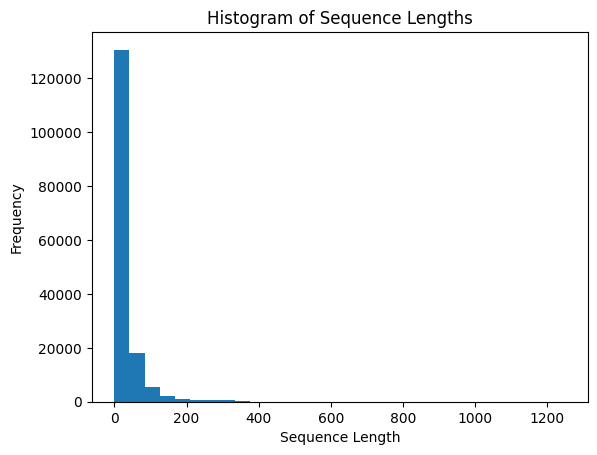

In [28]:
plt.hist(sequence_lengths, bins=30)
plt.title('Histogram of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

**Splitting The Data**

It is imperative for the model to be first evaluated on the validation dataset before passing our dataset, and therfore we utlized the module of Sklearn for splitting the trainset  

In [13]:

X = train_padded
y = train_data[categories].to_numpy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {len(X_train)}")
print(f"Validation set: {len(X_val)}")


Training set: 127656
Validation set: 31915


**Defining The LSTM Model**

The LSTM we have defined comprises of three key components: an Embedding layer, an LSTM layer, and a Dense layer. The Embedding layer transforms the input sequences of word indices into dense vectors of a fixed size. The LSTM layer, designed to process sequences and capture temporal dependencies, takes these embeddings as input. The Dense layer then maps the LSTM output to our desired output dimension, corresponding to the six categories of toxicity in our task. We chose this architecture because LSTMs are particularly well-suited for tasks involving sequential data, like text, as they can capture long-term dependencies in the data. By transforming the words into dense vectors, we can reduce the dimensionality of our data and capture semantic similarities between words. The Dense layer allows us to generate predictions for each of our six categories. We instantiate our model with a vocabulary size of 5000, an embedding dimension of 100, a hidden dimension of 256, and an output dimension of 6. This setup prepares our text data optimally for the LSTM model to perform the toxic comment classification task.

In [14]:

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):
        embedded = self.embedding(text)
        lstm_output, (hidden, cell) = self.lstm(embedded)
        final_output = self.fc(hidden.squeeze(0))
        
        return final_output

# Instantiate the model
model = LSTMClassifier(vocab_size=5000, embedding_dim=100, hidden_dim=256, output_dim=6)


As the train dataset was large, so we dcided to train the dataset in batches to reduce the computation time.

In [15]:

def get_batch(X, y, batch_size):
    '''
    Returns a batch (x, y) from the dataset
    '''
    indices = torch.randperm(len(X))[:batch_size]

    x = torch.from_numpy(X[indices])
    y = torch.from_numpy(y[indices]).float()  
    return x, y

In our project, we’re using the Binary Cross-Entropy with Logits Loss (BCEWithLogitsLoss) as our criterion. We chose this as it is particularly suitable for multi-label classification tasks like ours, where each comment can belong to multiple categories of toxicity. BCEWithLogitsLoss combines a Sigmoid layer and the BCELoss in one single class  makes it more numerically stable.
For the optimization algorithm, we’re using Adam as Adam is an adaptive learning rate optimization algorithm that’s been designed specifically for training deep neural networks. It’s known for its efficiency and the minimal memory requirement, which was crucial for our model.The learning rate of 0.001 is a commonly used value with the Adam optimizer. 

In [16]:

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

**Trainin the Model**

In [17]:

batch_size = 32
num_epochs = 10
for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        xb, yb = get_batch(X_train, y_train, batch_size)

        if torch.cuda.is_available():
            xb = xb.cuda()
            yb = yb.cuda()

        optimizer.zero_grad()

        output = model(xb)

        loss = criterion(output, yb)

        loss.backward()

        optimizer.step()

    print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.07413019984960556
Epoch 1, Loss: 0.024255601689219475
Epoch 2, Loss: 0.024507684633135796
Epoch 3, Loss: 0.009913172572851181
Epoch 4, Loss: 0.03376335650682449
Epoch 5, Loss: 0.014048085547983646
Epoch 6, Loss: 0.005882590543478727
Epoch 7, Loss: 0.019777150824666023
Epoch 8, Loss: 0.004180836025625467
Epoch 9, Loss: 0.034114010632038116


**Evaluating the Model on the Validation Data**

In [23]:

if not torch.is_tensor(X_val):
    X_val = torch.from_numpy(X_val)
if not torch.is_tensor(y_val):
    y_val = torch.from_numpy(y_val)

if torch.cuda.is_available():
    X_val = X_val.cuda()
    y_val = y_val.cuda()


model.eval()  
with torch.no_grad():
    predictions = model(X_val)

predictions = predictions.cpu().numpy()
y_val = y_val.cpu().numpy()

predicted_probs = torch.sigmoid(torch.from_numpy(predictions)).numpy()

predicted_labels = (predicted_probs > 0.5).astype(int)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
    report = classification_report(y_val, predicted_labels, target_names=categories, output_dict=True)


df = pd.DataFrame(report).transpose()
df


,precision,recall,f1-score,support
toxic,0.765310,0.682919,0.721771,3056.0
severe_toxic,0.381215,0.429907,0.404100,321.0
obscene,0.834037,0.691545,0.756136,1715.0
threat,0.461538,0.243243,0.318584,74.0
insult,0.711738,0.593556,0.647297,1614.0
identity_hate,0.625000,0.272109,0.379147,294.0
micro avg,0.741534,0.631467,0.682089,7074.0
macro avg,0.629806,0.485547,0.537839,7074.0
weighted avg,0.743311,0.631467,0.680238,7074.0
samples avg,0.059596,0.057030,0.055560,7074.0


From the results, we can see that the model performs well on some categories (like ‘toxic’ and ‘obscene’) but struggles with others (like ‘threat’ and ‘identity_hate’). This is due to the imbalance in the number of comments for each category in the training data.To improve these scores, we could consider several strategies. Firstly, addressing class imbalance through techniques like oversampling the minority class or undersampling the majority class would help to to deal with low F1 Scores.Furthermore we could use more sophisticated text preprocessing or feature engineering techniques, such as using pre-trained word embeddings or incorporating additional linguistic features, which could also enhance the model’s performance. 

**Performing on Test Data**


In [25]:

predicted_test_labels = []

for i in range(0, len(test_padded), batch_size):
    test_batch = test_padded[i : i + batch_size]
    test_batch = torch.tensor(test_batch)
    if torch.cuda.is_available():
        test_batch = test_batch.cuda()

    model.eval()  
    with torch.no_grad():
        batch_predictions = model(test_batch)

    batch_predictions = batch_predictions.cpu().numpy()

    predicted_batch_probs = torch.sigmoid(torch.from_numpy(batch_predictions)).numpy()

    predicted_batch_labels = (predicted_batch_probs > 0.5).astype(int)

    predicted_test_labels.extend(predicted_batch_labels)



test_labels = pd.read_csv(test_labels_file_path, on_bad_lines="skip")

test_labels = test_labels.drop(columns=['id'])

test_labels = test_labels.values
valid_label_indices = np.where(test_labels!=-1)


# print(predicted_labels)
# Use these indices to select only the valid labels and predictions
valid_test_labels = test_labels[valid_label_indices]
valid_predicted_labels = np.array(predicted_test_labels)[valid_label_indices[0]]

# Reshape valid_test_labels to be a 2D array
valid_test_labels = valid_test_labels.reshape(-1, 1)

valid_test_labels = np.repeat(valid_test_labels, 6, axis=1)


with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
    report = classification_report(valid_test_labels, valid_predicted_labels, target_names=categories,output_dict=True)


df = pd.DataFrame(report).transpose()
df




,precision,recall,f1-score,support
toxic,0.228726,0.818320,0.357522,14498.0
severe_toxic,0.495214,0.164161,0.246581,14498.0
obscene,0.334280,0.560422,0.418771,14498.0
threat,0.365140,0.019796,0.037556,14498.0
insult,0.353862,0.530280,0.424470,14498.0
identity_hate,0.425878,0.068561,0.118108,14498.0
micro avg,0.296122,0.360257,0.325056,86988.0
macro avg,0.367183,0.360257,0.267168,86988.0
weighted avg,0.367183,0.360257,0.267168,86988.0
samples avg,0.031404,0.013606,0.018230,86988.0


**Peforming on Real Sentences**

In [27]:
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
sentences = [
    "You are always so studpid idiot!",
    "I can't stand your rubbish behaviour , bloody retarted.",
    "Your constant terrorist is so annoying.",
    "I appreciate your shit feedback.",
    "Your ignorance is astounding and unacceptable."
]

processed_sentences = [process_text(sentence) for sentence in sentences]

sequences = tokenizer.texts_to_sequences(processed_sentences)

padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
padded_sequences = torch.from_numpy(padded_sequences)
if torch.cuda.is_available():
    padded_sequences = torch.from_numpy(padded_sequences).cuda()

model.eval()
with torch.no_grad():
    predictions = model(padded_sequences)


predictions = predictions.cpu().numpy()


predicted_probs = torch.sigmoid(torch.from_numpy(predictions)).numpy()


predicted_labels = (predicted_probs > 0.5).astype(int)

for i in range(len(predicted_labels)):
    print(f"Sentence: {sentences[i]}")
    print(f"Predicted labels for sentence {i+1}:")
    for j in range(len(categories)):
        print(f"{categories[j]}: {predicted_labels[i][j]}")
    print("\n")

Sentence: You are always so studpid idiot!
Predicted labels for sentence 1:
toxic: 1
severe_toxic: 0
obscene: 0
threat: 0
insult: 1
identity_hate: 0


Sentence: I can't stand your rubbish behaviour , bloody retarted
Predicted labels for sentence 2:
toxic: 1
severe_toxic: 0
obscene: 0
threat: 0
insult: 0
identity_hate: 0


Sentence: Your constant terrorist is so annoying.
Predicted labels for sentence 3:
toxic: 1
severe_toxic: 0
obscene: 0
threat: 0
insult: 0
identity_hate: 0


Sentence: I appreciate your shit feedback.
Predicted labels for sentence 4:
toxic: 1
severe_toxic: 0
obscene: 1
threat: 0
insult: 0
identity_hate: 0


Sentence: Your ignorance is astounding and unacceptable.
Predicted labels for sentence 5:
toxic: 0
severe_toxic: 0
obscene: 0
threat: 0
insult: 0
identity_hate: 0


